In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import os
import sys
sys.path.append('./datasets_and_samplers')
from myGeoDatasets import Maxar
from mySamplers import MyGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
from samplers_utils import boundingBox_2_Polygon
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import supervision as sv



In [3]:
#args
country = 'TheGambia'
root = ''
quiet = False
#_______________________

dataset_links = pd.read_csv(os.path.join(root, 'dataset-links.csv'))
country_links = dataset_links[dataset_links.Location == country]
#eventualmente filtrare anche sul quadkey
if not quiet:
    print(f"Found {len(country_links)} links for {country}")

gdfs = []
for _, row in country_links.iterrows():
    df = pd.read_json(row.Url, lines=True)
    

Found 6 links for TheGambia


In [2]:
#args
country = 'TheGambia'
root = ''
quiet = False
#_______________________

dataset_links = pd.read_csv(os.path.join(root, 'dataset-links.csv'))
country_links = dataset_links[dataset_links.Location == country]
#eventualmente filtrare anche sul quadkey
if not quiet:
    print(f"Found {len(country_links)} links for {country}")

gdfs = []
for _, row in country_links.iterrows():
    df = pd.read_json(row.Url, lines=True)
    df["geometry"] = df["geometry"].apply(shape)
    gdf_down = gpd.GeoDataFrame(df, crs=4326)
    gdfs.append(gdf_down)

gdfs = pd.concat(gdfs)

Found 6 links for TheGambia


In [33]:
type(df.geometry.iloc[0])

shapely.geometry.polygon.Polygon

In [4]:
dataset = Maxar('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031213.tif')
sampler = MyGridGeoSampler(dataset, size=600, stride=600)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
data_crs = dataset.crs

In [7]:
from build_seg_utils import building_gdf
gdfs_32628 = building_gdf('TheGambia', dataset_crs = data_crs)

Found 6 links for TheGambia


In [11]:
#gdfs_32628 = gdfs.to_crs(data_crs)
index_MS_buildings = gdfs_32628.sindex

In [8]:
def rel_bbox_coords(geodf:gpd.GeoDataFrame,
                    ref_coords:tuple,
                    res,
                    ext_mt = None):
    """
    Returns the relative coordinates of a bbox w.r.t. a reference bbox in the 'geometry' column

    Inputs:
        geodf: dataframe with bboxes
        ref_coords: a tuple in the format (minx, miny, maxx, maxy)
        res: resolution of the image
        ext_mt: meters to to each edge of the box (the center remains fixed)
    Returns:
        a list of tuples with the relative coordinates of the bboxes [(minx, miny, maxx, maxy), ...]
    """
    result = []
    ref_minx, ref_maxy = ref_coords[0], ref_coords[3] #coords of top left corner
    #print('\nref_coords top left: ', ref_minx, ref_maxy )
    for geom in geodf['geometry']:
        building_minx, building_miny, building_maxx, building_maxy = geom.bounds
        if ext_mt != None:
            building_minx -= (ext_mt / 2)
            building_miny -= (ext_mt / 2)
            building_maxx += (ext_mt / 2)
            building_maxy += (ext_mt / 2)
        #print('\nBefore building_tuple: ', building_minx, building_miny, building_maxx, building_maxy)
        #print('After building_tuple: ', building_minx - ref_minx, ref_maxy - building_miny, building_maxx - ref_minx, ref_maxy - building_maxy)
        #reslut.append((building_minx - ref_minx, building_miny - ref_maxy, building_maxx - ref_minx, building_maxy - ref_maxy))
        #rel_bbox_coords = tuple(np.array([building_minx - ref_minx, building_miny - ref_maxy, building_maxx - ref_minx, building_maxy - ref_maxy]) / res)
        rel_bbox_coords = tuple(np.array([building_minx - ref_minx, ref_maxy - building_maxy, building_maxx - ref_minx, ref_maxy - building_miny]) / res)
        result.append(rel_bbox_coords)
    
    return result

def rel_polyg_coord(geodf:gpd.GeoDataFrame,
                    ref_coords:tuple,
                    res):
    """
    Returns the relative coordinates of a polygon w.r.t. a reference bbox

    Inputs:
        geodf: dataframe with polygons in the 'geometry' column
        ref_coords: a tuple in the format (minx, miny, maxx, maxy)
        res: resolution of the image
    Returns:
        a list of lists of tuples with the relative coordinates of the bboxes [[(p1_minx1, p1_miny1), (p1_minx2, p1_miny2), ...], [(p2_minx1, p2_miny1), (p2_minx2, p2_miny2), ...], ...]
    """
    result = []
    ref_minx, ref_maxy = ref_coords[0], ref_coords[3] #coords of top left corner

    for geom in geodf['geometry']:
        x_s, y_s = geom.exterior.coords.xy
        rel_x_s = (np.array(x_s) - ref_minx) / res
        rel_y_s = (ref_maxy - np.array(y_s)) / res
        rel_coords = list(zip(rel_x_s, rel_y_s))
        result.append(rel_coords)
    return result   

In sampler
tile_polygon:  POLYGON ((320156.25 1489843.75, 315455.322265625 1489843.75, 315470.63516642543 1492342.8892077415, 320156.25 1491748.5059546148, 320156.25 1489843.75))
In plot
Crs EPSG:32628
sx_low:  (317590.33203125, 1489843.75)
dx_high:  (317773.4375, 1490026.85546875)
(482.47007156658174, 558.8019019813538, 581.5792835056305, 671.4130183532715)


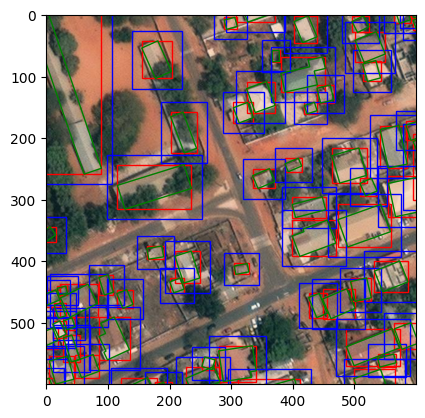

In [12]:
dataset_res = dataset.res
i=0
for batch in dataloader:
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])
    hits = index_MS_buildings.query(query_bbox_poly)

    if len(hits) > 30:
        i+=1
        if i >5:
            sample = unbind_samples(batch)[0]
            img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')
            #img= img.permute(1, 2, 0).numpy().astype('uint8')
            #img = img.numpy()
            #img = img.astype('uint8')
            #plt.imshow(img)

            fig, ax2 = dataset.plot(sample)

            building_boxes = rel_bbox_coords(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res)
            for tup in building_boxes:
                minx, miny, maxx, maxy = tup
                rect = patches.Rectangle((minx, miny), maxx - minx, maxy - miny, linewidth=1, edgecolor='r', facecolor='none')            
                ax2.add_patch(rect)
            
            building_boxes = rel_bbox_coords(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res, ext_mt=10)
            for box in building_boxes:
                x0, y0 = box[0], box[1]
                w, h = box[2] - box[0], box[3] - box[1]
                rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='b', facecolor='none')            
                ax2.add_patch(rect)
            
            for rel_pol in rel_polyg_coord(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res):
                poly = patches.Polygon(rel_pol, linewidth=1, edgecolor='g', facecolor='none')
                ax2.add_patch(poly)
            print(building_boxes[0])
            
            break

In [8]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "./creating_labels/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda')

predictor = SamPredictor(sam)

In [9]:

predictor.set_image(img4Sam)

In [10]:
import torch
building_boxes_t = torch.tensor(building_boxes, device=predictor.device)
#print(building_boxes_t)

#Given the box coorindates as xyxy return the center of the rectangle
point_coords = torch.tensor([[(sublist[0] + sublist[2])/2, (sublist[1] + sublist[3])/2] for sublist in building_boxes_t], device=predictor.device)
#print(point_coords.shape)
point_labels = torch.tensor([1] * point_coords.shape[0], device=predictor.device)
#print(point_labels)

transformed_points = predictor.transform.apply_coords_torch(point_coords, img4Sam.shape[:2]).unsqueeze(1)
transformed_boxes = predictor.transform.apply_boxes_torch(building_boxes_t, img4Sam.shape[:2])
#print(transformed_boxes.shape)

In [17]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=75):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='y', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='r', facecolor=(0,0,0,0), lw=0.5))


def plot_w_wo_masks(img, masks, boxes, pt_coords, pt_labels, only_pred=False, only_masks = False):
    
    if not only_pred:
        fig = plt.figure(figsize=(15, 15))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.imshow(img)

        ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
        ax2.imshow(img)
        for mask in masks:
            show_mask(mask.cpu().numpy(), ax2)
        if not only_masks:
            for box in boxes:
                show_box(box.cpu().numpy(), ax2)
            for point, label in zip(pt_coords.cpu(), pt_labels.cpu()):
                show_points(point.cpu().numpy(), label.cpu().numpy(), ax2)
        
        ax2.set_xlim([0, img.shape[1]])
        ax2.set_ylim([img.shape[0], 0])

        ax1.axis('off')
        ax2.axis('off')
    else:
        fig = plt.figure(figsize=(7, 7))
        plt.imshow(img)

        for mask in masks:
            show_mask(mask.cpu().numpy(), plt.gca())
        for box in boxes:
            show_box(box.cpu().numpy(), plt.gca())
        for point, label in zip(pt_coords.cpu(), pt_labels.cpu()):
            show_points(point.cpu().numpy(), label.cpu().numpy(), plt.gca())
        
        plt.gca().set_xlim([0, img.shape[1]])
        plt.gca().set_ylim([img.shape[0], 0])

        plt.gca().axis('off')
        



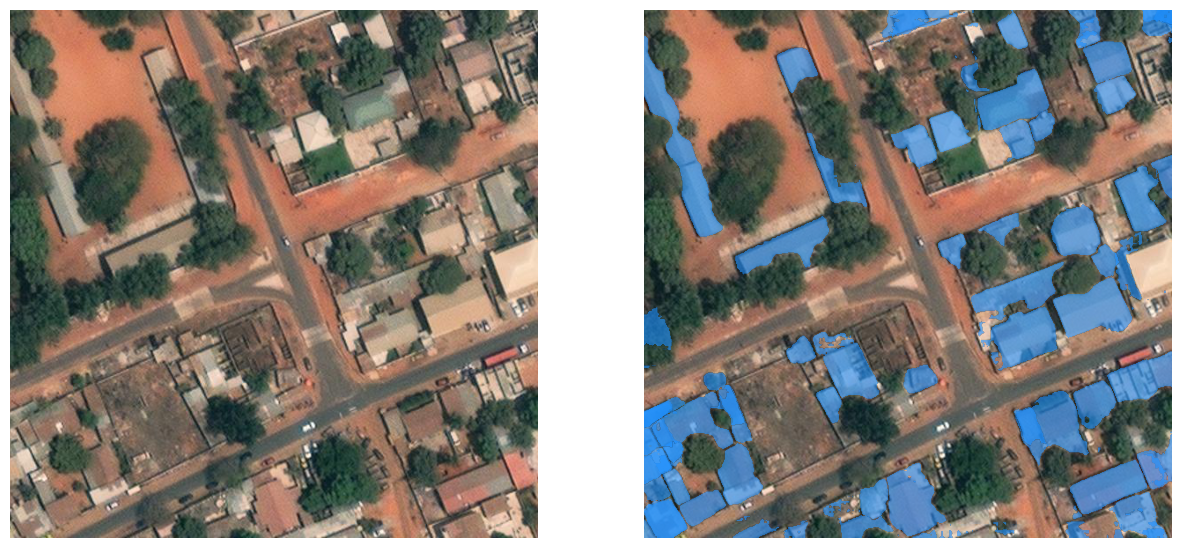

In [19]:
masks, _, _ = predictor.predict_torch(
                point_coords=None,
                point_labels=None,
                boxes=transformed_boxes,
                multimask_output=False,
            )

plot_w_wo_masks(img4Sam, masks, building_boxes_t, point_coords, point_labels, only_pred=False, only_masks=True)

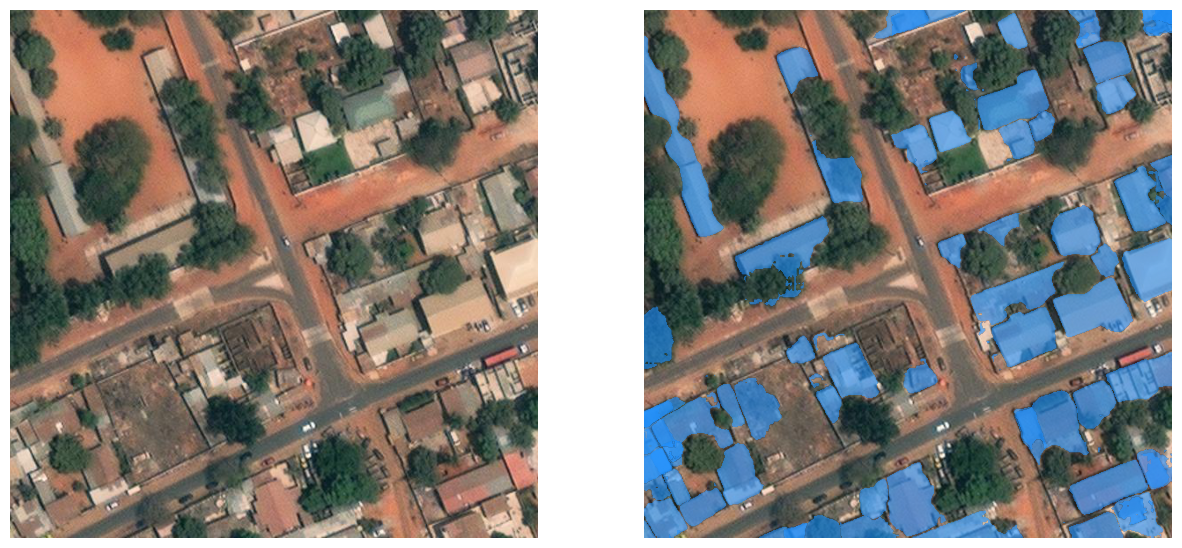

In [20]:
masks, _, _ = predictor.predict_torch(
                point_coords=transformed_points,
                point_labels=point_labels[:, None],
                boxes=transformed_boxes,
                multimask_output=False,
                    )

plot_w_wo_masks(img4Sam, masks, building_boxes_t, point_coords, point_labels, only_pred=False, only_masks=True)

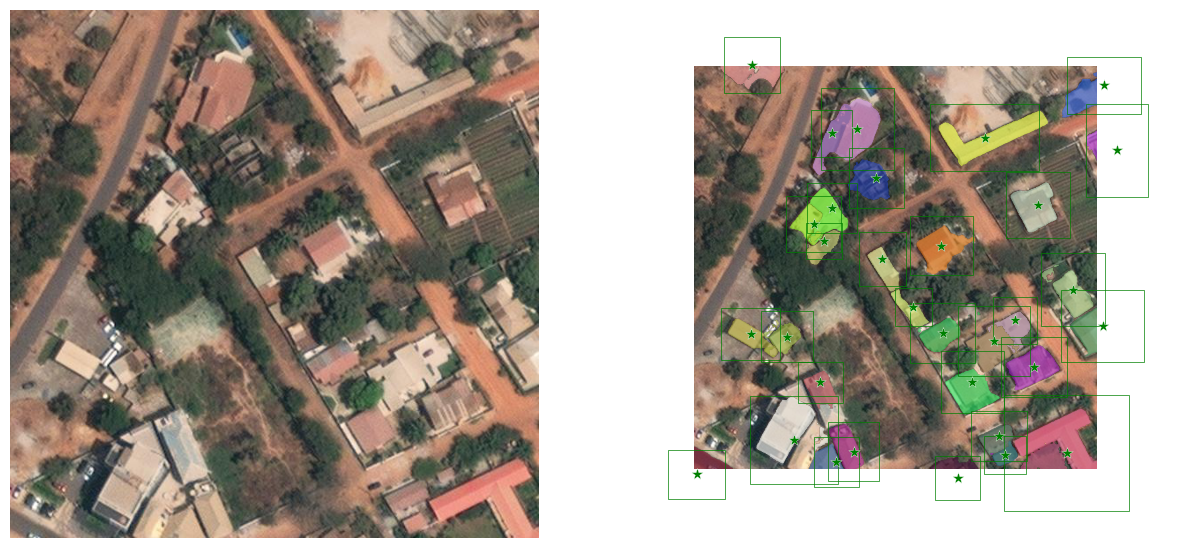

In [42]:
"""masks, _, _ = predictor.predict_torch(
                point_coords=None,
                point_labels=None,
                boxes=transformed_boxes,
                multimask_output=False,
            )"""


masks, _, _ = predictor.predict_torch(
                point_coords=transformed_points,
                point_labels=point_labels[:, None],
                boxes=transformed_boxes,
                multimask_output=False,
                    )

fig = plt.figure(figsize=(15, 15))
ax2 = fig.add_subplot(122, frameon=True)
ax2.imshow(img4Sam)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in building_boxes_t:
    show_box(box.cpu().numpy(), plt.gca())
for point, label in zip(point_coords.cpu(), point_labels.cpu()):
    show_points(coords=point, labels = label, ax = plt.gca())

ax1 = fig.add_subplot(121, frameon=False)
ax1.imshow(img4Sam)
ax1.axis('off')
ax2.axis('off')
plt.show()

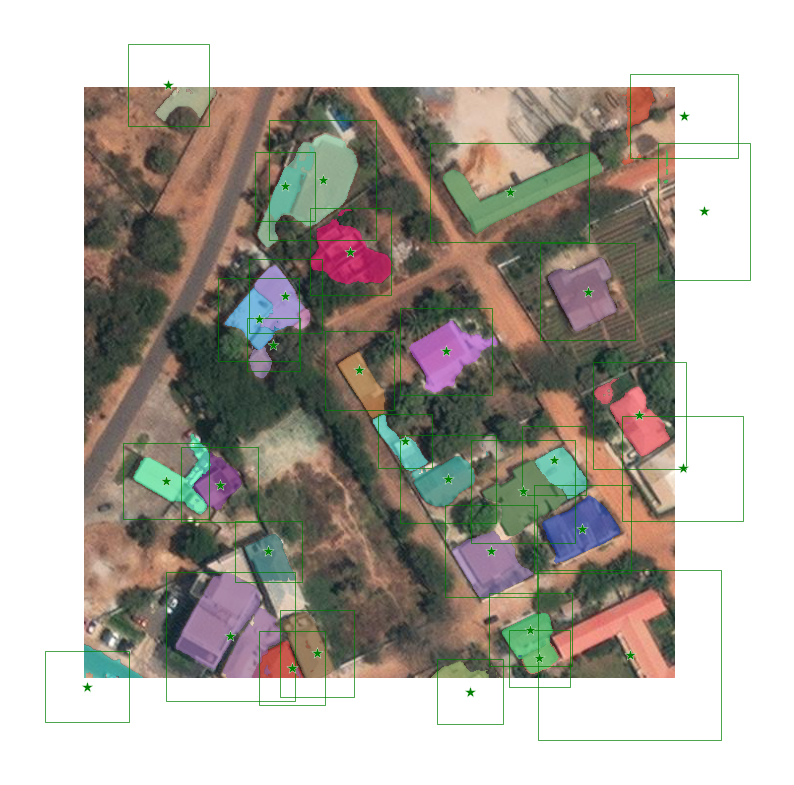

In [41]:
masks, _, _ = predictor.predict_torch(
                point_coords=None,
                point_labels=None,
                boxes=transformed_boxes,
                multimask_output=False,
            )


"""masks, _, _ = predictor.predict_torch(
                point_coords=transformed_points,
                point_labels=point_labels[:, None],
                boxes=transformed_boxes,
                multimask_output=False,
                    )"""

plt.figure(figsize=(10, 10))
plt.imshow(img4Sam)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in building_boxes_t:
    show_box(box.cpu().numpy(), plt.gca())
for point, label in zip(point_coords.cpu(), point_labels.cpu()):
    show_points(coords=point, labels = label, ax = plt.gca())

plt.axis('off')
plt.show()

In [58]:
input_point = np.array([[200, 50]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

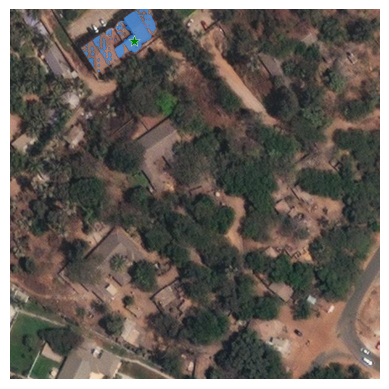

In [55]:
plt.imshow(img4Sam)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [69]:
from segment_anything import SamAutomaticMaskGenerator
mask_generator = SamAutomaticMaskGenerator(sam)
upscaled_image = cv2.resize(img4Sam, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
sam_result = mask_generator.generate(upscaled_image)

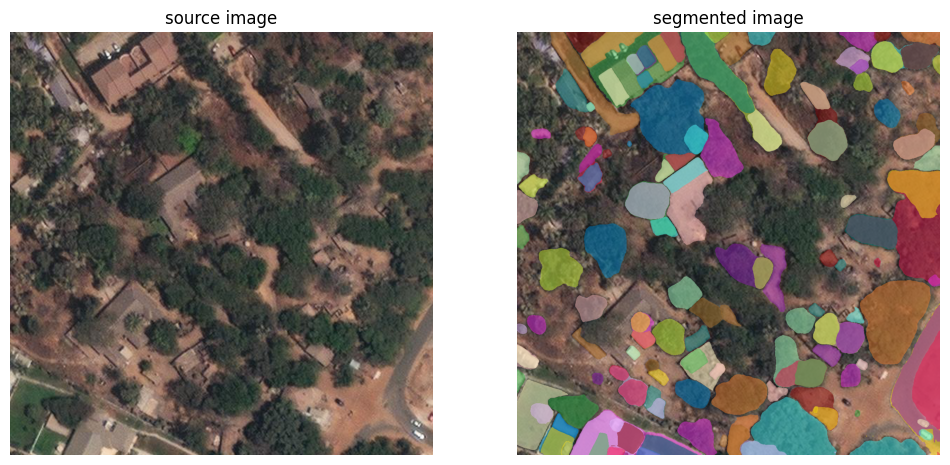

In [70]:

image_bgr = cv2.cvtColor(upscaled_image, cv2.COLOR_RGB2BGR)
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [99]:
mask_predictor = SamPredictor(sam)

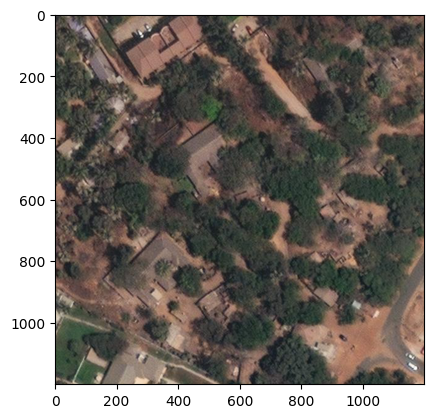

In [104]:
plt.imshow(upscaled_image)

In [106]:
mask_predictor.set_image(upscaled_image)
box = np.array([150, 1200, 400, 1100])
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

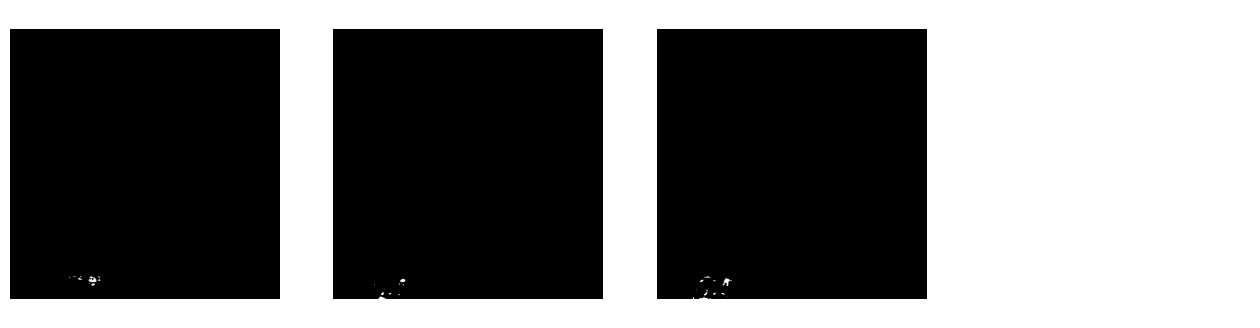

In [107]:
sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

In [101]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

ValueError: operands could not be broadcast together with shapes (1200,1200,1) (480,640,3) (480,640,3) 